In [7]:
import pandas as pd
import os
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle

file_name = 'fxReynoldsV3.xlsx'
file_path = os.path.join(os.getcwd(), file_name)

ANNDF = pd.read_excel(file_path)

X = ANNDF.iloc[:, [1, 3]].values
Y = ANNDF.iloc[:, 2].values.reshape(-1, 1)

X, Y = shuffle(X, Y)

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, train_size=0.75)  # 30% for testing and shuffle

scalerx = StandardScaler()
scalery = StandardScaler()

Xtrain = scalerx.fit_transform(xtrain)
Ytrain = scalery.fit_transform(ytrain)

mlp = MLPRegressor(max_iter=5000)

nneurons = [1, 2, 4, 8, 16, 32, 64, 128]
parameters = {'hidden_layer_sizes': [],
              'activation': ['relu', 'tanh', 'logistic'],
              'solver': ['adam']
}

for n in nneurons:
    parameters['hidden_layer_sizes'].append((n,))

for n1 in nneurons:
    for n2 in nneurons:
        parameters['hidden_layer_sizes'].append((n1, n2))

kf = KFold(n_splits=10, shuffle=True)

gsearchcv = GridSearchCV(estimator=mlp, param_grid=parameters, cv=kf, verbose=2)
gsearchcv.fit(Xtrain, Ytrain.ravel())

bestac = gsearchcv.best_score_ * 100  # Convert to percentage
bestparam = gsearchcv.best_params_

print('Best Accuracy: {:.2f} %'.format(bestac))
print('Best Parameters:', bestparam)

Xtest_scaled = scalerx.transform(xtest)
ypred = gsearchcv.predict(Xtest_scaled).reshape(-1, 1)
ypred_or = scalery.inverse_transform(ypred)

r2 = r2_score(ytest, ypred_or)
rmse = mean_squared_error(ytest, ypred_or, squared=False)

r2, rmse


import joblib

# Após o treinamento do modelo
joblib.dump(gsearchcv.best_estimator_, 'mlp_17122024.pkl')
joblib.dump(scalerx, 'scalerx_17122024.pkl')
joblib.dump(scalery, 'scalery_17122024.pkl')

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.1s
[CV] END activation=relu, hidden_layer_sizes=(1,), solver=adam; total time=   0.0s
[CV] END activation=relu, hidden_layer_sizes=(2,), solver=adam; total time=   0.0s
[CV] END activation=re

c:\Users\T2F\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


['scalery_17122024.pkl']

['scalery.pkl']

In [8]:
def cor1(Re):
    f = 2.344 * np.power(Re,-0.081) #correlação kaixin yan  300 < RE <3100
    return f

def cor2(Re):
    f = 2.765 * np.power(Re,-0.166) #correlação kaixin yan  300 < RE <3100
    return f

Recor1 = np.linspace(1000,3100,15)
stpkyan = [0.3745] * len(Recor1)

In [10]:
import numpy as np
import plotly.graph_objs as go
import plotly.offline as pyo



# Definir os intervalos para Re e Stdp
Re_vals = np.linspace(200, 8000, 100)  # Valores de Reynolds de 1000 a 8000
Stdp_vals = np.linspace(0.2992, 0.4331, 100)  # Valores de Stdp de 0.3326 a 0.4331

f_formula =  0.68877 - np.power(0.00024174,Re_vals) + 1.0322e-09 * Re_vals**2+ 4.8409e-05 * Re_vals
# Criar uma grade de Re e Stdp
Re_grid, Stdp_grid = np.meshgrid(Re_vals, Stdp_vals)
grid_points = np.c_[Re_grid.ravel(), Stdp_grid.ravel()]

# Prever os valores de 'f' usando a ANN nos pontos da grade
f_pred_scaled = gsearchcv.predict(scalerx.transform(grid_points))
f_pred = scalery.inverse_transform(f_pred_scaled.reshape(-1, 1))
f_pred_grid = f_pred.reshape(Re_grid.shape)

# Calcular a superfície usando a fórmula fornecida
f_formula = (4.3059 / np.log(Re_grid + 3.1918)) + ((0.30649 / Stdp_grid) - 0.80937)

# Criar o gráfico 3D para os resultados da ANN com contornos
surface_ann = go.Surface(
    x=Re_grid, y=Stdp_grid, z=f_pred_grid, 
    colorscale='Viridis',
    name='Superfície ANN',
    colorbar=dict(title='ANN f', len=0.5, x=0.9),
    contours={
        "z": {
            "show": True,
            "start": np.min(f_pred_grid),
            "end": np.max(f_pred_grid),
            "size": (np.max(f_pred_grid) - np.min(f_pred_grid)) / 20,  # Ajustar o espaçamento dos contornos
            "color": "black",
        }
    }
)

# Criar o gráfico 3D para a fórmula fornecida com contornos
surface_formula = go.Surface(
    x=Re_grid, y=Stdp_grid, z=f_formula, 
    colorscale='Plasma',
    name='Superfície Fórmula',
    opacity=0.7,
    colorbar=dict(title='Fórmula f', len=0.5, x=1.05),
    contours={
        "z": {
            "show": True,
            "start": np.min(f_formula),
            "end": np.max(f_formula),
            "size": (np.max(f_formula) - np.min(f_formula)) / 20,
            "color": "black",
        }
    }
)

# Scatter plot dos valores originais
scatter_cor = go.Scatter3d(
    x=Recor1,  # Valores de Reynolds
    y=stpkyan,  # Valores de Stdp
    z=cor2(Recor1),  # Valores de 'f'
    mode='markers',
    marker=dict(size=5, color='black'),
    name='Kaixin Yan et. al (Polished)'
)

scatter_cor2 = go.Scatter3d(
    x=xtest[:,0],  # Valores de Reynolds
    y=xtest[:,1],  # Valores de Stdp
    z=ypred_or.flatten(),  # Valores de 'f'
    mode='markers',
    marker=dict(size=5, color='red', symbol = 'diamond'),
    name='Predict / Validation'
)



# Scatter plot dos valores originais
scatter_data = go.Scatter3d(
    x=ANNDF.iloc[:, 0].values,  # Valores de Reynolds
    y=ANNDF.iloc[:, 2].values,  # Valores de Stdp
    z=ANNDF.iloc[:, 1].values,  # Valores de 'f'
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Valores Originais'
)

# Definir o layout do gráfico
layout = go.Layout(
    title='Superfície de Resultados da ANN e da Fórmula com Valores Originais',
    scene=dict(
        xaxis=dict(title='Reynolds Number (Re)', backgroundcolor='white', gridcolor='lightgrey'),
        yaxis=dict(title='Stdp', backgroundcolor='white', gridcolor='lightgrey'),
        zaxis=dict(title='f', backgroundcolor='white', gridcolor='lightgrey'),
        bgcolor='white'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    showlegend=True
)

# Criar a figura com ambas as superfícies e o scatter plot
fig = go.Figure(data=[surface_ann, scatter_cor, scatter_cor2], layout=layout)

# Mostrar o gráfico
pyo.plot(fig)


'temp-plot.html'

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import LeaveOneOut

file_name = 'fxReynoldsV3.xlsx'
file_path = os.path.join(os.getcwd(), file_name)

ANNDF = pd.read_excel(file_path)

X = ANNDF.iloc[:, [1, 3]].values
Y = ANNDF.iloc[:, 2].values.reshape(-1, 1)

X, Y = shuffle(X, Y)

loocv = LeaveOneOut()
loocv.get_n_splits(X)

mlp = MLPRegressor(max_iter=5000)

nneurons = [1, 2, 4, 8, 16, 32, 64, 128]
parameters = {'hidden_layer_sizes': [],
            'activation': ['relu', 'logistic'],
            'solver': ['adam']
}

for n in nneurons:
    parameters['hidden_layer_sizes'].append((n,))

for n1 in nneurons:
    for n2 in nneurons:
        parameters['hidden_layer_sizes'].append((n1, n2))

ypred_or = []
ytest_val = []
bestparam = []
bestac    = []

for i, (train_index, test_index) in enumerate(loocv.split(X)):
    print(i+1)
    xtrain = X[train_index,:]
    xtest  = X[test_index,:]

    ytrain = Y[train_index,:]
    ytest  = Y[test_index,:]

    scalerx = StandardScaler()
    scalery = StandardScaler()

    Xtrain = scalerx.fit_transform(xtrain)
    Ytrain = scalery.fit_transform(ytrain)

    kf = KFold(n_splits=5, shuffle=True) #max 5...

    gsearchcv = GridSearchCV(estimator=mlp, param_grid=parameters, cv=kf, verbose=0)
    gsearchcv.fit(Xtrain, Ytrain.ravel())

    bestac.append(gsearchcv.best_score_ * 100)  # Convert to percentage
    bestparam.append(gsearchcv.best_params_)

    print('Best Accuracy: {:.2f} %'.format(bestac[i]))
    print('Best Parameters:', bestparam[i])

    Xtest_scaled = scalerx.transform(xtest)
    ypred = gsearchcv.predict(Xtest_scaled).reshape(-1, 1)
    ypred_or.append(scalery.inverse_transform(ypred))
    ytest_val.append(ytest)

import joblib

# Após o treinamento do modelo
joblib.dump(gsearchcv.best_estimator_, 'mlp_model_14_12_2024_loocv.pkl')
joblib.dump(scalerx, 'scalerx_mlp_model_14_12_2024loocv.pkl')
joblib.dump(scalery, 'scalery_mlp_model_14_12_2024loocv.pkl')



1
Best Accuracy: 99.41 %
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 128), 'solver': 'adam'}
2
Best Accuracy: 99.31 %
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 128), 'solver': 'adam'}
3
Best Accuracy: 99.29 %
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 128), 'solver': 'adam'}
4
Best Accuracy: 99.06 %
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 128), 'solver': 'adam'}
5
Best Accuracy: 99.28 %
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 128), 'solver': 'adam'}
6
Best Accuracy: 99.34 %
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 128), 'solver': 'adam'}
7
Best Accuracy: 99.22 %
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 128), 'solver': 'adam'}
8
Best Accuracy: 99.33 %
Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (128, 128), 'solver': 'adam'}
9
Best Accuracy: 99.23 %
Best Parameters: {'activation': 'relu',

['scalery_mlp_model_14_12_2024loocv.pkl']

In [2]:
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_percentage_error

ypred_or = [items for subList in ypred_or for items in subList]
ytest_val = [items for subList in ytest_val for items in subList]

r2 = r2_score(ytest_val, ypred_or)
rmse = root_mean_squared_error(ytest_val, ypred_or)
mape = mean_absolute_percentage_error(ytest_val, ypred_or)

In [6]:
print(ypred_or)

[array([0.6328121]), array([0.57555592]), array([0.59898921]), array([0.66094225]), array([0.67578952]), array([0.60683756]), array([0.6033502]), array([0.58104148]), array([0.56487333]), array([0.64217368]), array([0.58521339]), array([0.53024755]), array([0.60444973]), array([0.58474323]), array([0.64176753]), array([0.54872829]), array([0.71805039]), array([1.02884349]), array([0.53932958]), array([0.65470393]), array([0.56973834]), array([0.56251258]), array([0.67969642]), array([0.60277525]), array([0.64791993]), array([0.91118698]), array([0.60885116]), array([0.55412676]), array([0.62422151]), array([0.58423306]), array([0.57359092]), array([0.7131899]), array([0.52410509]), array([0.73148874]), array([0.58898633]), array([0.61747746]), array([0.56008366]), array([0.56666444]), array([0.78769251]), array([0.5459796]), array([0.57244044]), array([0.53863928]), array([0.56234723]), array([0.64571709]), array([0.54649199]), array([0.5850416]), array([0.52867408]), array([0.55978278

In [3]:
print(r2)
print(rmse)

0.9932490455399093
0.007696227832359033


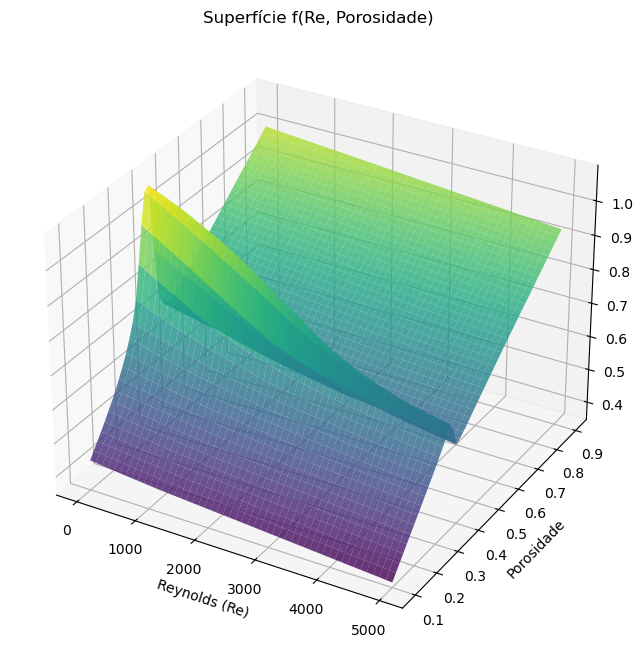

In [4]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Carregar o modelo treinado e os scalers
mlp_model = joblib.load('mlp_model_14_12_2024_loocv.pkl')
scalerx = joblib.load('scalerx_mlp_model_14_12_2024loocv.pkl')
scalery = joblib.load('scalery_mlp_model_14_12_2024loocv.pkl')

# 2. Criar uma grade de valores para Re e Porosidade
Re_values = np.linspace(10, 5000, 50)  # Exemplo de range para Reynolds
Porosidade_values = np.linspace(0.1, 0.9, 50)  # Exemplo de range para porosidade

# Criar meshgrid para superfície
Re, Porosidade = np.meshgrid(Re_values, Porosidade_values)

# Combinar em um array 2D para o modelo prever
input_data = np.c_[Re.ravel(), Porosidade.ravel()]

# 3. Escalar os dados
input_data_scaled = scalerx.transform(input_data)

# 4. Previsão do modelo
f_pred_scaled = mlp_model.predict(input_data_scaled).reshape(-1, 1)

# 5. Inverter a escala do output (f)
f_pred = scalery.inverse_transform(f_pred_scaled)

# 6. Reshape para formato de grid
f_pred = f_pred.reshape(Re.shape)

# 7. Plotar a superfície
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Superfície
ax.plot_surface(Re, Porosidade, f_pred, cmap='viridis', alpha=0.8)

# Rótulos e títulos
ax.set_title('Superfície f(Re, Porosidade)')
ax.set_xlabel('Reynolds (Re)')
ax.set_ylabel('Porosidade')
ax.set_zlabel('f')

plt.show()


In [9]:
mlp = MLPRegressor(max_iter=5000)

nneurons = [1, 2, 4, 8, 16, 32, 64, 128]
parameters = {'hidden_layer_sizes': [],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam']
}

for n in nneurons:
    parameters['hidden_layer_sizes'].append((n,))

for n1 in nneurons:
    for n2 in nneurons:
        parameters['hidden_layer_sizes'].append((n1, n2))

parameters

{'hidden_layer_sizes': [(1,),
  (2,),
  (4,),
  (8,),
  (16,),
  (32,),
  (64,),
  (128,),
  (1, 1),
  (1, 2),
  (1, 4),
  (1, 8),
  (1, 16),
  (1, 32),
  (1, 64),
  (1, 128),
  (2, 1),
  (2, 2),
  (2, 4),
  (2, 8),
  (2, 16),
  (2, 32),
  (2, 64),
  (2, 128),
  (4, 1),
  (4, 2),
  (4, 4),
  (4, 8),
  (4, 16),
  (4, 32),
  (4, 64),
  (4, 128),
  (8, 1),
  (8, 2),
  (8, 4),
  (8, 8),
  (8, 16),
  (8, 32),
  (8, 64),
  (8, 128),
  (16, 1),
  (16, 2),
  (16, 4),
  (16, 8),
  (16, 16),
  (16, 32),
  (16, 64),
  (16, 128),
  (32, 1),
  (32, 2),
  (32, 4),
  (32, 8),
  (32, 16),
  (32, 32),
  (32, 64),
  (32, 128),
  (64, 1),
  (64, 2),
  (64, 4),
  (64, 8),
  (64, 16),
  (64, 32),
  (64, 64),
  (64, 128),
  (128, 1),
  (128, 2),
  (128, 4),
  (128, 8),
  (128, 16),
  (128, 32),
  (128, 64),
  (128, 128)],
 'activation': ['relu', 'tanh', 'logistic'],
 'solver': ['adam']}